In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from videoreader import VideoReader
import deepdish as dd
from datetime import datetime
import time
import scipy.interpolate
from samplestamps import *
from samplestamps.utils import *

In [2]:
# read data
# datenames = ['localhost-20180703_172731','localhost-20180703_182840','localhost-20180703_125914','localhost-20180703_140359', 'localhost-20180703_151105', 'localhost-20180703_161930']
# dirnames = ['mictest','mictest','dat.processed','dat','dat','dat']
datenames = ['localhost-20181016_121526']
dirnames = ['dat']
idx = 0

datename = datenames[idx]
dirname = dirnames[idx]
rootname = '/Volumes/ukme04/#Common/chainingmic'

filename = f'{rootname}/{dirname}/{datename}/{datename}_timeStamps.h5'
with h5py.File(filename) as f:
    cam_stamps = f['timeStamps'][:]

filename = f'{rootname}/{dirname}/{datename}/{datename}_daq.h5'
with h5py.File(filename) as f:
    daq_stamps = f['systemtime'][:]
    daq_sampleinterval = f['samplenumber'][:]
    daq_samples = f['samples'][:300000,:]  
daq_samplenumber = np.cumsum(daq_sampleinterval)[:,np.newaxis]

filename = f'{rootname}/res/{datename}/{datename}_tracks.h5'
track_data = dd.io.load(filename)
led = track_data['led']

# get starttimes from log files parse log files - first line contains "started"
filename = f'{rootname}/{dirname}/{datename}/{datename}_daq.log'
daq_start = time_from_log(filename)

filename = f'{rootname}/{dirname}/{datename}/{datename}_ptg.log'
ptg_start = time_from_log(filename)

Fs = 10000
fps = 100

1539685025.228 1539684927.385496


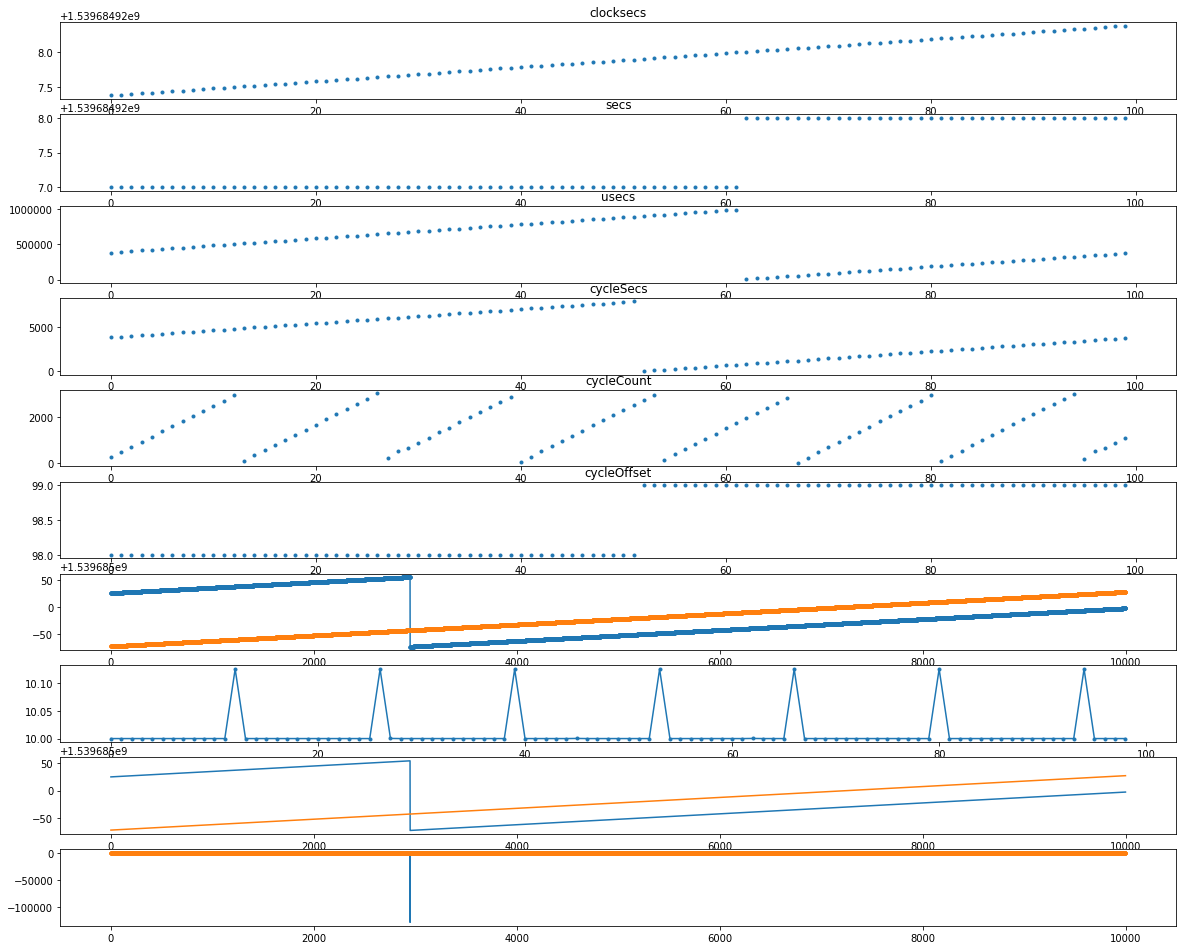

In [4]:
# convert on-frame timestamps to time
ts_labels = ['clocksecs', 'secs', 'usecs', 'cycleSecs','cycleCount','cycleOffset']

plt.gcf().set_size_inches(20, 20)
for ii in range(cam_stamps.shape[-1]):
    plt.subplot(cam_stamps.shape[-1]+6,1,ii+2)
    plt.plot(cam_stamps[:100,ii],'.')
    plt.title(ts_labels[ii])

# convert timestamps to shuttertimes (in seconds?)
shutterTime =  cam_stamps[:,5]+cam_stamps[:,3]/8000 + cam_stamps[0,1] -cam_stamps[0,4]/1000#Time of "Shutter OFF" for each frame the camera was capturing
plt.subplot(cam_stamps.shape[-1]+6,1,ii+3)
plt.plot(shutterTime[:10000],'.-')
plt.plot(cam_stamps[:10000,0],'.-')
print(shutterTime[0], cam_stamps[0,0])

plt.subplot(cam_stamps.shape[-1]+6,1,ii+4)
plt.plot(np.diff(shutterTime[:100])*1000,'.-')

shutterTimes = cam_stamps[:,1] + cam_stamps[:,2]/1000000;#Time of "Shutter OFF" for each frame the camera was capturing
plt.subplot(cam_stamps.shape[-1]+6,1,ii+5)
plt.plot(shutterTime[:10000])
plt.plot(cam_stamps[:10000,0])

plt.subplot(cam_stamps.shape[-1]+6,1,ii+6)
plt.plot(np.diff(shutterTime[:10000])*1000)
plt.plot(np.diff(cam_stamps[:10000,0])*1000,'.');


1539684934.8926 seconds is time of sample 10000.0
1539684927.3855 seconds is time of frame 1
sample 10000 occurred at frame : 751
sample 0 occurred at frame: 651, assuming stable daq clock of 10000 Hz.
this corresponds to a delay between cam and daq of 6510.0 milliseconds assuming a stable frame rate of 100 frames per second.
time stamps taken from log files yield a delay cam to daq delay of 6524.0 milliseconds.
error between "timestamped" and "logged" delay is -14.0 milliseconds.


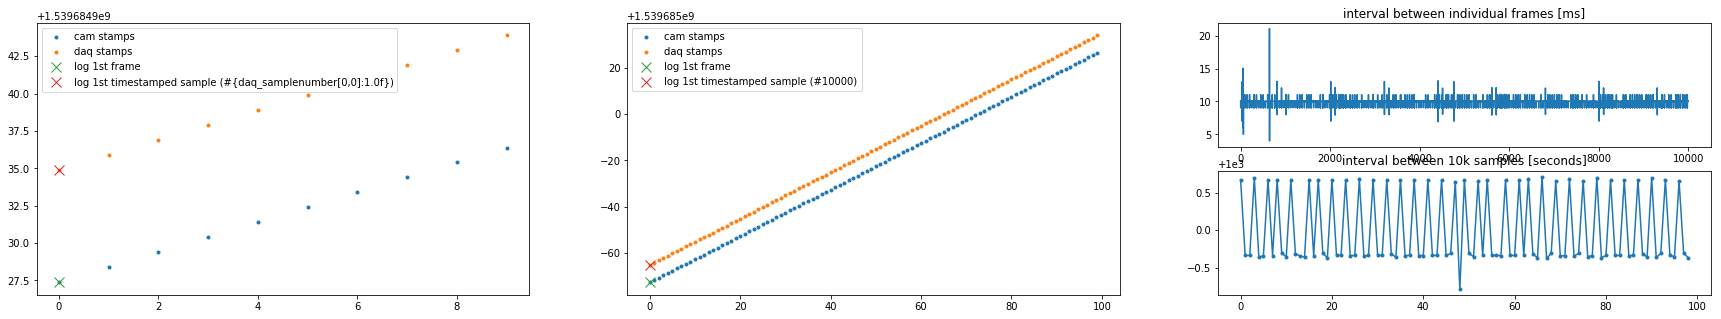

In [80]:
# estimate delay between daq and cam based on time stamps either from frames and samples or from log files
logtime_1st_frame = (time.mktime(ptg_start.timetuple()) + ptg_start.microsecond / 1E6)
logtime_1st_sample = (time.mktime(daq_start.timetuple()) + daq_start.microsecond / 1E6)
logtime_1st_timestamped_sample = (time.mktime(daq_start.timetuple()) + daq_start.microsecond / 1E6) + daq_samplenumber[0,0]/Fs

framenumber_1st_timestamped_sample = np.argmax(cam_stamps[:,0]>=daq_stamps[0,0])
framenumber_1st_sample = np.argmax(cam_stamps[:,0]>=daq_stamps[0,0]-daq_samplenumber[0,0]/Fs)

plt.gcf().set_size_inches(30,5)
plt.subplot(131)
plt.plot(cam_stamps[:1000:100,0],'.')
plt.plot(daq_stamps[:10,0],'.')
plt.plot(0, logtime_1st_frame, 'x', markersize=10)
plt.plot(0, logtime_1st_timestamped_sample, 'x', markersize=10)
plt.legend(['cam stamps', 'daq stamps', 'log 1st frame', 'log 1st timestamped sample (#{daq_samplenumber[0,0]:1.0f})'])

plt.subplot(132)
plt.plot(cam_stamps[:10000:100,0],'.')
plt.plot(daq_stamps[:100,0],'.')
plt.plot(0, logtime_1st_frame, 'x', markersize=10)
plt.plot(0, logtime_1st_timestamped_sample, 'x', markersize=10)
plt.legend(['cam stamps', 'daq stamps', 'log 1st frame', f'log 1st timestamped sample (#{daq_samplenumber[0,0]:1.0f})'])

plt.subplot(233)
plt.title('interval between individual frames [ms]')
plt.plot(np.diff(cam_stamps[:10000,0])*1000)

plt.subplot(236)
plt.plot(np.diff(daq_stamps[:100,0])*1000, '.-')
plt.title('interval between 10k samples [seconds]')
print(f'{daq_stamps[0,0]:1.4f} seconds is time of sample {daq_samplenumber[0,0]}')
print(f'{cam_stamps[0,0]:1.4f} seconds is time of frame {1}')
print(f'sample {daq_samplenumber[0,0]:1.0f} occurred at frame : {framenumber_1st_timestamped_sample}')
print(f'sample 0 occurred at frame: {framenumber_1st_sample}, assuming stable daq clock of {Fs} Hz.')
print(f'this corresponds to a delay between cam and daq of {framenumber_1st_sample/fps*1000:1.1f} milliseconds assuming a stable frame rate of {fps} frames per second.')
print(f'time stamps taken from log files yield a delay cam to daq delay of {(logtime_1st_sample-logtime_1st_frame)*1000:1.1f} milliseconds.')
print(f'error between "timestamped" and "logged" delay is {framenumber_1st_sample/fps*1000 - (logtime_1st_sample-logtime_1st_frame)*1000:1.1f} milliseconds.')


(300000, 18)
led was supposed to be triggered 0 seconds (0 samples) into the daq recording - is this correct?
actual led onset in daq at 0 samples = 0.0 ms.
actual led onset in cam at 28 frames = 280.0 ms.
so first sample occurred after 280 ms = 28 frames.
error between "timestamped" and "signal extracted" delay is 6230.0 milliseconds.


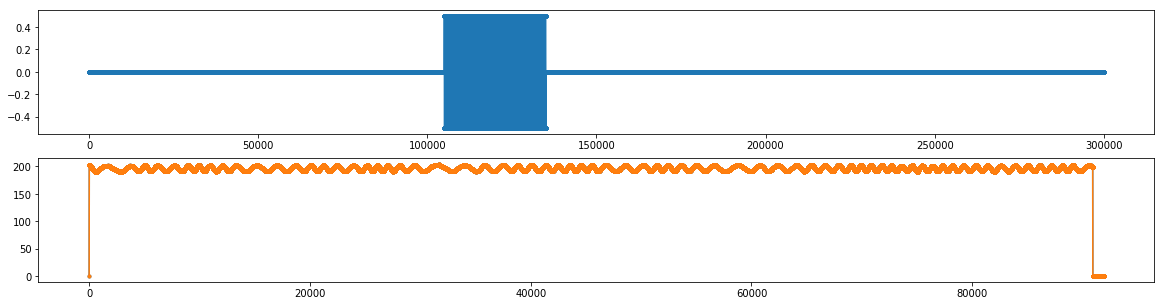

In [81]:
# estimate delay between daq and cam based on driving voltage and resulting led onsets
print(daq_samples.shape)
plt.gcf().set_size_inches(20,5)
plt.subplot(211)
plt.plot(daq_samples[:,-1],'.-')
plt.subplot(212)
plt.plot(led[...,0],'.-')

prestimulusdelay_seconds = 0;  # seconds (sample) in stimulus at which LED is driven
prestimulusdelay_samples = prestimulusdelay_seconds*Fs;

if daq_samples.shape[1]<18:
    print('did not record daq - cannot estimate ledonset_daq_samples')
    ledonset_daq_samples = -123456789
else:
    ledonset_daq_samples = np.argmax(daq_samples[:10000,-1]>0.1)

ledonset_daq_seconds = ledonset_daq_samples/Fs

ledonset_cam_frames = np.argmax(led[:1000])
ledonset_cam_seconds = ledonset_cam_frames/fps

print(f'led was supposed to be triggered {prestimulusdelay_seconds} seconds ({prestimulusdelay_samples} samples) into the daq recording - is this correct?')
print(f'actual led onset in daq at {ledonset_daq_samples:1.0f} samples = {ledonset_daq_seconds*1000} ms.')
print(f'actual led onset in cam at {ledonset_cam_frames:1.0f} frames = {ledonset_cam_seconds*1000} ms.')
print(f'so first sample occurred after {(ledonset_cam_seconds-ledonset_daq_seconds-prestimulusdelay_seconds)*1000:1.0f} ms = {(ledonset_cam_seconds-ledonset_daq_seconds-prestimulusdelay_seconds)*fps:1.0f} frames.')
print(f'error between "timestamped" and "signal extracted" delay is {framenumber_1st_sample/fps*1000 - (ledonset_cam_seconds-ledonset_daq_seconds-prestimulusdelay_seconds)*1000:1.1f} milliseconds.')

In [82]:
# init
sample_clock_offset = 0
frame_clock_offset = 0
sample_time_first = daq_stamps[0,0]-daq_samplenumber[0,0]/Fs
frame_time_first = cam_stamps[0,0]
print(f'daq start: {sample_time_first:1.3f} s, cam start: {frame_time_first:1.3f} s, delay: {sample_time_first-frame_time_first:1.3f} s')
# get frames for a given sample or samples for a given frame based on time stamp
target_time = sample_time_first
frame_number_target = samplenumber_from_timestamps(target_time, cam_stamps[:12000,0])
sample_number_target = samplenumber_from_timestamps(target_time, daq_stamps[:-100,0], daq_samplenumber[:-100,0])
print(f'\ntarget time {target_time:1.3f} this corresponds to:')
print(f'   frame  {frame_number_target}')
print(f'   sample {sample_number_target}')
# get range for a given sample or samples for a given frame based on time stamp
target_epoch = [target_time, target_time+.1]

frame_numberrange_target = samplerange_from_timestamps(target_epoch, cam_stamps[:12000,0])
sample_numberrange_target = samplerange_from_timestamps(target_epoch, daq_stamps[:-100,0], daq_samplenumber[:-100,0])
print(f'\ntarget epoch {target_epoch[0]:1.3f}:{target_epoch[1]:1.3f} (duration {target_epoch[1]-target_epoch[0]:1.3f} s) this corresponds to:')
print(f'   frames  {frame_numberrange_target[0]}:{frame_numberrange_target[-1]}')
print(f'   samples  {sample_numberrange_target[0]}:{sample_numberrange_target[-1]}')

daq start: 1539684933.893 s, cam start: 1539684927.385 s, delay: 6.507 s

target time 1539684933.893 this corresponds to:
   frame  650
   sample 7

target epoch 1539684933.893:1539684933.993 (duration 0.100 s) this corresponds to:
   frames  650:659
   samples  7:1005


led onsets at sample 105000.0 corresponding to
   seconds: 1539684944.393
   frame: 1700.


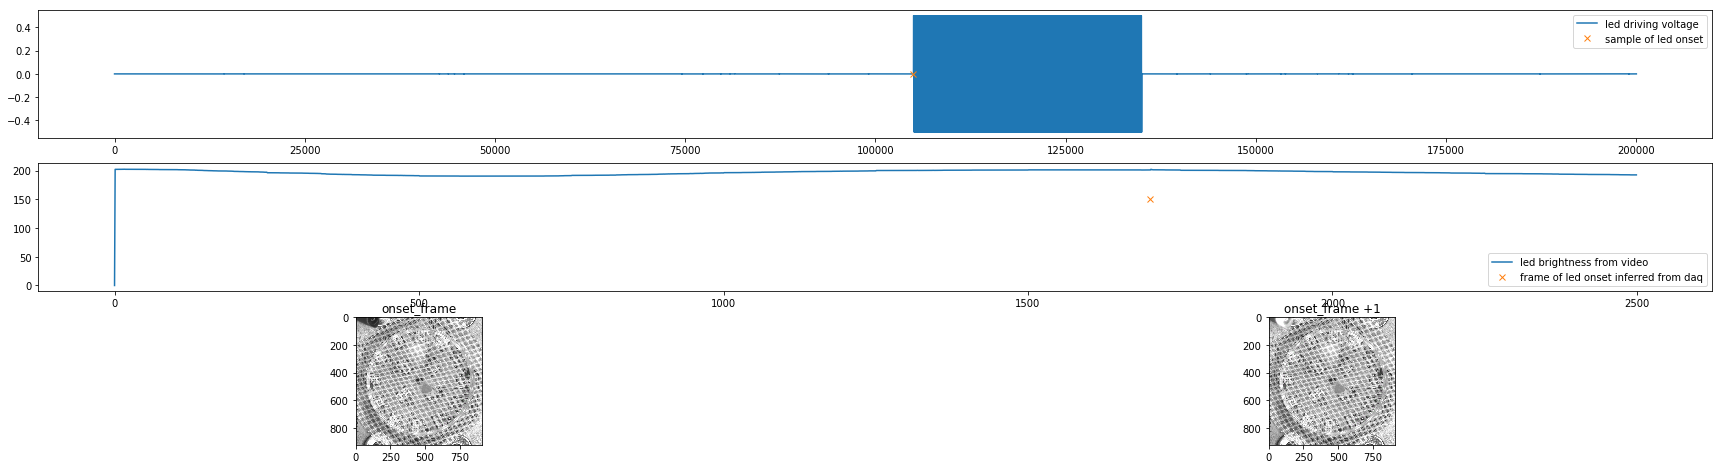

In [83]:
# test functional interface - get samples at led onsets and vice versa
ledonset_sample = 80000.0+np.argmax(daq_samples[80000:,-1]>0.05)
ledonset_time = timestamp_from_samplenumber(ledonset_sample, daq_stamps[:-100,0], daq_samplenumber[:-100,0])
ledonset_frame = samplenumber_from_timestamps(ledonset_time, cam_stamps[:20000,0])

print(f'led onsets at sample {ledonset_sample} corresponding to')
print(f'   seconds: {ledonset_time:1.3f}')
print(f'   frame: {ledonset_frame:1.0f}.')

plt.gcf().set_size_inches(30, 8)
plt.subplot(311)
plt.plot(daq_samples[:200000,-1])
plt.plot(ledonset_sample, 0, 'x')
plt.legend(['led driving voltage', 'sample of led onset'])

plt.subplot(312)
plt.plot(led[:2500, 0,0])
plt.plot(ledonset_frame, 150, 'x')
plt.legend(['led brightness from video', 'frame of led onset inferred from daq'])


filename = f'{rootname}/{dirname}/{datename}/{datename}.avi'
vr = VideoReader(filename)
plt.subplot(325)
plt.imshow(vr[ledonset_frame])
plt.title('onset_frame')
plt.subplot(326)
plt.imshow(vr[ledonset_frame+1])
plt.title('onset_frame +1');

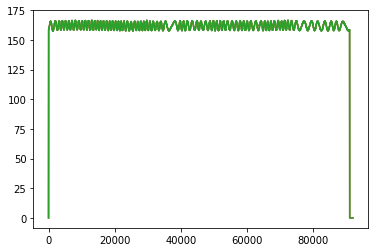

In [35]:
track_data.keys()
plt.plot(track_data['led'][...,0])

In [60]:
# test object which will store interpolator for faster reuse
ss = SampStamp(sample_times=daq_stamps[:,0], frame_times=cam_stamps[:,0], sample_numbers=daq_samplenumber[:,0])
ledonset_sample = 80000.0+np.argmax(daq_samples[80000:,-1]>0.05)
print(f'led onset at sample {ledonset_sample} corresponding to')
print(f'   seconds: {ss.sample_time(ledonset_sample):1.3f}')
print(f'   frame: {ss.frame(ledonset_sample):1.0f}.')


led onsets at sample 105000.0 corresponding to
   seconds: 1547469697.975
   frame: 1721.


In [62]:
# benchmark the functional and the object interfaces
import time
t0 = time.clock()
iterations = 100
for _ in range(iterations):
    ledonset_time = timestamp_from_samplenumber(ledonset_sample, daq_stamps[:-100,0], daq_samplenumber[:-100,0])
    ledonset_frame = samplenumber_from_timestamps(ledonset_time, cam_stamps[:12000,0])
tdur_function = time.clock() - t0

t0 = time.clock()
ss = SampStamp(sample_times=daq_stamps[:,0], frame_times=cam_stamps[:,0], sample_numbers=daq_samplenumber[:,0])
for _ in range(iterations):
    ss.frame(ledonset_sample)
tdur_object = time.clock() - t0

print(f"For {iterations} iterations, the")
print(f"   functional interface took {tdur_function:1.3f} seconds.")
print(f"   object interface took {tdur_object:1.3f} seconds.")
print(f"That's a {tdur_function/tdur_object} fold speed-up.")

For 100 iterations, the
   functional interface took 0.215 seconds.
   object interface took 0.027 seconds.
That's a 8.08755500394921 fold speed-up.
